In [10]:
import os, sys, json
import scipy.stats
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from datasets import load_dataset


In [11]:
# get the data from huggingface
dataset = load_dataset("yelp_review_full")
dataset_test = dataset["test"]



### Prepare ground truth

In [12]:
# convert to json
data = []
for i in range(len(dataset_test)):
    data.append({"text": dataset_test[i]["text"], "gt_label": dataset_test[i]["label"]})

In [13]:
data_df = {x['text']: x for x in data}

In [14]:
data

[{'text': 'I got \'new\' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \\nI took the tire over to Flynn\'s and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he\'d give me a new tire \\"this time\\". \\nI will never go back to Flynn\'s b/c of the way this guy treated me and the simple fact that they gave me a used tire!',
  'gt_label': 0},
 {'text': "Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.",
  'gt_l

### Append your baseline results

In [15]:
path_predicted_labels = "/home/anmola/assignments_hw/sentiment-cartography/v2_dir_512_large/inference_results.json"
path_logit_scores = "/home/anmola/assignments_hw/sentiment-cartography/single_v2_dir_512_large/inference_results.json"

In [16]:
with open(path_predicted_labels, "r") as f:
    predicted_df = json.load(f)
with open(path_logit_scores, "r") as f:
    logit_df = json.load(f)

In [17]:
def find_matched_pairs(s1, arr_s):
    # find indexes of all elements in arr_s that s1 is a substring of
    matched_pairs = []
    for i, s in enumerate(arr_s):
        if s1 in s:
            matched_pairs.append(i)
    assert(len(matched_pairs) > 0)
    assert(len(matched_pairs)==1)
    return matched_pairs

In [18]:
all_keys = list(data_df.keys())
for elem in tqdm.tqdm(predicted_df):
    curr_review_text = elem["review"]
    if curr_review_text in data_df:
        matched_review_text = curr_review_text
    else:
        matched_key_idx = find_matched_pairs(curr_review_text, all_keys)
        matched_review_text = all_keys[matched_key_idx[0]]
    assert("multi_class_predicted_label" not in data_df[matched_review_text])
    data_df[matched_review_text]["multiclass_predicted_label"] = elem["predicted_label"]

100%|██████████| 50000/50000 [00:12<00:00, 3875.20it/s]


In [19]:
for elem in tqdm.tqdm(logit_df):
    curr_review_text = elem["review"]
    if curr_review_text in data_df:
        matched_review_text = curr_review_text
    else:
        matched_key_idx = find_matched_pairs(curr_review_text, all_keys)
        matched_review_text = all_keys[matched_key_idx[0]]
    assert("single_class_logit_score" not in data_df[matched_review_text])
    logits = elem["logit_scores"]
    softmax_scores = scipy.special.softmax(logits)
    assert(len(softmax_scores) == 2)
    data_df[matched_review_text]["single_class_logit_score"] = softmax_scores[1]
    #break

100%|██████████| 50000/50000 [00:13<00:00, 3708.15it/s]


In [20]:
### Load Diddee's api scores
api_scores_path = "/home/anmola/assignments_hw/sentiment-cartography/data/didee_google_results.jsonl"
api_scores_data = []
with open(api_scores_path, "r") as f:
    for line in f:
        api_scores_data.append(json.loads(line))

In [21]:
api_scores_data[0]

{'input': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.",
 'score': 0.6520000100135803,
 'magnitude': 3.815000057220459,
 'label': 4}

In [22]:
# for elem in api_scores_data:
#     curr_review_text = elem["input"]
#     if curr_review_text in data_df:
#         matched_review_text = curr_review_text
#     else:
#         matched_key_idx = find_matched_pairs(curr_review_text, all_keys)
#         matched_review_text = all_keys[matched_key_idx[0]]
#     assert("google_api_score" not in data_df[matched_review_text])
#     data_df[matched_review_text]["google_api_score"] = elem["score"]
#     assert("google_api_magnitude" not in data_df[matched_review_text])
#     data_df[matched_review_text]["google_api_magnitude"] = elem["magnitude"]
   

## Merge Kwang's data

In [23]:
polar_coordinates_csv_path = "/home/anmola/assignments_hw/sentiment-cartography/data/kwanghee_polar_coordinates.csv"
polar_coordinates_df = pd.read_csv(polar_coordinates_csv_path)

# retain only those values in `split=test`
polar_coordinates_df = polar_coordinates_df[polar_coordinates_df["split"] == "test"]
# rename columns
rename_mapping = {'pos':"pos_loss", "neg": "neg_loss", "ori": "base_loss"}
for key in rename_mapping:
    polar_coordinates_df = polar_coordinates_df.rename(columns={key: rename_mapping[key]})

In [24]:
polar_coordinates_df.columns

Index(['pos_loss', 'neg_loss', 'base_loss', 'text', 'label', 'split'], dtype='object')

In [25]:
polar_coordinates_df

,pos_loss,neg_loss,base_loss,text,label,split
650000,3.637170,3.423840,4.001163,I got 'new' tires from them and within two wee...,0,test
650001,3.356954,3.033727,4.223260,Don't waste your time. We had two different p...,0,test
650002,3.785630,3.524564,4.136008,All I can say is the worst! We were the only 2...,0,test
650003,3.353036,2.869883,3.647495,I have been to this restaurant twice and was d...,0,test
650004,3.176172,2.873306,3.618195,Food was NOT GOOD at all! My husband & I ate h...,0,test
...,...,...,...,...,...,...
699995,3.798547,3.646442,3.949870,Just wanted to write a review to chip in with ...,0,test
699996,2.362278,3.172081,3.590026,Great ambience. Great drinks. Great food. I lo...,4,test
699997,3.373806,3.480679,4.198580,I have been to the other Monks locations so I ...,3,test
699998,3.848746,3.583591,4.204350,Don't go here. I know you might want to try i...,1,test


In [26]:
def _get_polar(pos_loss, neg_loss, base_loss):
    pos = np.exp(pos_loss - base_loss)
    neg = np.exp(neg_loss- base_loss)
    r = np.sqrt((pos ** 2 + neg ** 2))
    theta = np.arctan(neg / pos)
    theta_in_degrees = np.degrees(theta)
    return r, theta, theta_in_degrees

In [27]:
# add new columns ie polar_radius, polar_theta
for row in polar_coordinates_df.iterrows():
    r, theta, theta_in_degrees = _get_polar(row[1]["pos_loss"], row[1]["neg_loss"], row[1]["base_loss"])
    polar_coordinates_df.at[row[0], "polar_radius"] = r
    polar_coordinates_df.at[row[0], "polar_theta"] = theta
    polar_coordinates_df.at[row[0], "polar_theta_deg"] = theta_in_degrees

In [28]:
polar_coordinates_df

,pos_loss,neg_loss,base_loss,text,label,split,polar_radius,polar_theta,polar_theta_deg
650000,3.637170,3.423840,4.001163,I got 'new' tires from them and within two wee...,0,test,0.893337,0.679533,38.934379
650001,3.356954,3.033727,4.223260,Don't waste your time. We had two different p...,0,test,0.519094,0.626527,35.897380
650002,3.785630,3.524564,4.136008,All I can say is the worst! We were the only 2...,0,test,0.889150,0.656323,37.604547
650003,3.353036,2.869883,3.647495,I have been to this restaurant twice and was d...,0,test,0.875254,0.552706,31.667748
650004,3.176172,2.873306,3.618195,Food was NOT GOOD at all! My husband & I ate h...,0,test,0.799081,0.636228,36.453198
...,...,...,...,...,...,...,...,...,...
699995,3.798547,3.646442,3.949870,Just wanted to write a review to chip in with ...,0,test,1.133103,0.709637,40.659229
699996,2.362278,3.172081,3.590026,Great ambience. Great drinks. Great food. I lo...,4,test,0.720631,1.152153,66.013533
699997,3.373806,3.480679,4.198580,I have been to the other Monks locations so I ...,3,test,0.655790,0.838733,48.055875
699998,3.848746,3.583591,4.204350,Don't go here. I know you might want to try i...,1,test,0.883173,0.654348,37.491350


In [29]:
# convert to json
polar_coordinates_data = []
all_cols = list(polar_coordinates_df.columns)
for i in range(len(polar_coordinates_df)):
    polar_coordinates_data.append({x: polar_coordinates_df.iloc[i][x] for x in all_cols})

In [30]:
polar_coordinates_data[0]

{'pos_loss': 3.6371703147888175,
 'neg_loss': 3.423840284347534,
 'base_loss': 4.001162528991699,
 'text': 'I got \'new\' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \\nI took the tire over to Flynn\'s and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he\'d give me a new tire \\"this time\\". \\nI will never go back to Flynn\'s b/c of the way this guy treated me and the simple fact that they gave me a used tire!',
 'label': 0,
 'split': 'test',
 'polar_radius': 0.8933369212390614,
 'polar_theta': 0.6795331120882492,
 'polar_theta_deg': 38.93437936204698}

In [31]:
for elem in polar_coordinates_data:
    curr_review_text = elem["text"]
    if curr_review_text in data_df:
        matched_review_text = curr_review_text
    else:
        matched_key_idx = find_matched_pairs(curr_review_text, all_keys)
        matched_review_text = all_keys[matched_key_idx[0]]
    cols_transfer = ["polar_radius", "polar_theta", "polar_theta_deg", 'pos_loss', 'neg_loss', 'base_loss']
    for col in cols_transfer:
        # assert(col not in data_df[matched_review_text])
        data_df[matched_review_text][col] = elem[col]


In [32]:
data_df[matched_review_text]

{'text': "Buffet was recently open after renovation so my husband and I are thinking it should be pretty good....wrong. We arrived at 8:30 am for what we thought was a Saturday brunch offering champs, nope. Price is $21.95 but on Monday - Friday is $18.95...same food so why the increase? I can go to the Fiesta in Henderson with champs and better food for $8.99 Sat/Sun but we wanted to try something we thought was going to be an upgrade....lol what a joke. \\n\\n\\nFood: everything I tried looked and tasted like food was leftover from the day before and reheated. \\n\\nShrimps were all water logged, the crab legs had a brownish color to them with an odd taste. \\n\\nPastries none..all offerings were donuts. They did have a fresh crepe bar, but then again looked very dry. I didn't want to stand on line for crepe paper. \\n\\nOverall I'm rating this one star because I have no choice.",
 'gt_label': 0,
 'multiclass_predicted_label': 1,
 'single_class_logit_score': 0.00017183152926799749,
 

In [33]:
#elem['poss_loss']

In [34]:
for elem in data_df:
    if "Wing sauce is like water." in elem:
        print(elem)
        print(data_df[elem])
        break

In [35]:
# for elem in dataset['train']:
#     if "Wing sauce is like water." in elem['text']:
#         print(elem)

In [36]:
# convert data_df to a dataframe
data_arr = data_df.values()
data_df = pd.DataFrame(data_arr)

In [37]:
def test_significance(df_train, metric1, metric2):
    # filter columns habing nan in any of the columns
    df_use = df_train.dropna(subset=[metric1, metric2])
    print(f"Number of rows after dropping NaNs: {len(df_use)}")
    correlation, p_value = scipy.stats.spearmanr(df_use[metric1], df_use[metric2])
    print(f'Correlation between {metric1} and {metric2}')
    print(f"Correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")
    significant = False
    if p_value < 0.05:
        significant = True 
    return {
                    "metric1": metric1,
                    "metric2": metric2,
                    "correlation": correlation, 
                    "p-value": p_value, 
                    "signficant": significant
                }

def plot(df_train, column1, column2, label_col=None, prefix='Raw'):
    plt.figure(figsize=(8, 6))
    
    # Plot regression line
    sns.regplot(
        x=df_train[column1],
        y=df_train[column2],
        scatter=False,  # Hide default scatter points
        color='green'
    )
    
    # Overlay scatter plot with colors based on labels
    if label_col is not None:
        sns.scatterplot(
            x=df_train[column1],
            y=df_train[column2],
            hue=df_train[label_col],
            palette='Set1',
            alpha=0.5,
            s=20
        )
        plt.legend(title='Label')
    else:
        # Default scatter points if no labels are provided
        sns.scatterplot(
            x=df_train[column1],
            y=df_train[column2],
            color='blue',
            alpha=0.5
        )
    
    # Add titles and labels
    plt.title(f'Scatter Plot of {column1} vs {column2} | {prefix}')
    plt.xlabel(f'{column1}')
    plt.ylabel(f'{column2}')
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'./corr_plots/{column1}_{column2}_{prefix}_correlation.png', dpi=600)
    # plt.show()
    plt.cla()  # Clear current axes
    plt.clf()  # Clear entire current figure
    plt.close()  # Close window

Calculating correlation between gt_label and gt_label
Number of rows after dropping NaNs: 50000
Correlation between gt_label and gt_label
Correlation coefficient: 0.9999999999999999
P-value: 0.0
############################
Calculating correlation between gt_label and multiclass_predicted_label
Number of rows after dropping NaNs: 50000
Correlation between gt_label and multiclass_predicted_label
Correlation coefficient: 0.8457933062696361
P-value: 0.0
############################
Calculating correlation between gt_label and single_class_logit_score
Number of rows after dropping NaNs: 50000
Correlation between gt_label and single_class_logit_score
Correlation coefficient: 0.8445710317055284
P-value: 0.0
############################
Calculating correlation between gt_label and polar_radius
Number of rows after dropping NaNs: 49995
Correlation between gt_label and polar_radius
Correlation coefficient: -0.07294239969582175
P-value: 5.945181531079789e-60
############################
Calculat

KeyboardInterrupt: 

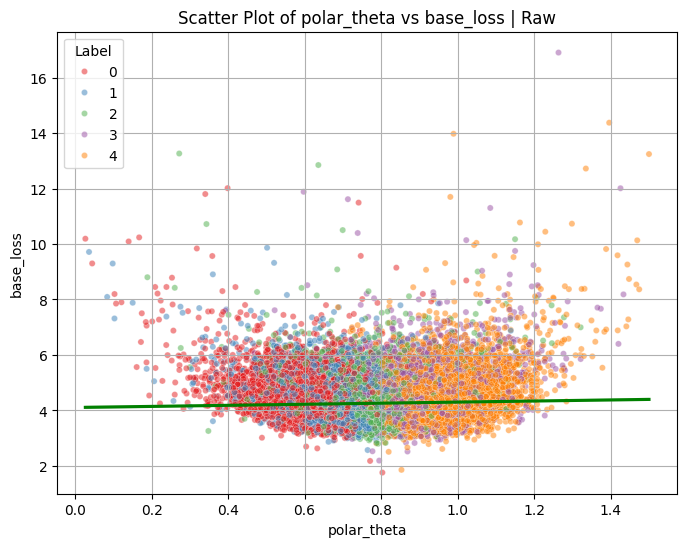

In [38]:
# for all numerical columns in data_df, calculate correlation among each other using
# also, plot a 2d color plot of the correlation matrix
numerical_cols = data_df.select_dtypes(include=[np.number]).columns
correlation_matrix = np.zeros((len(numerical_cols), len(numerical_cols)))
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        metric1 = numerical_cols[i]
        metric2 = numerical_cols[j]
        print(f"Calculating correlation between {metric1} and {metric2}")
        ans = test_significance(data_df, metric1, metric2)
        correlation_matrix[i][j] = ans["correlation"]
        corr_score, p_val = ans["correlation"], ans["p-value"]
        # correlation_matrix[j][i] = ans["correlation"]
        prefix_use = f"Correlation: {round(corr_score, 4)}, p-value: {round(p_val, 5)} "
        if i<j:
            plot(data_df, metric1, metric2, "gt_label")
            # break
        print("############################")
    # break

<Axes: >

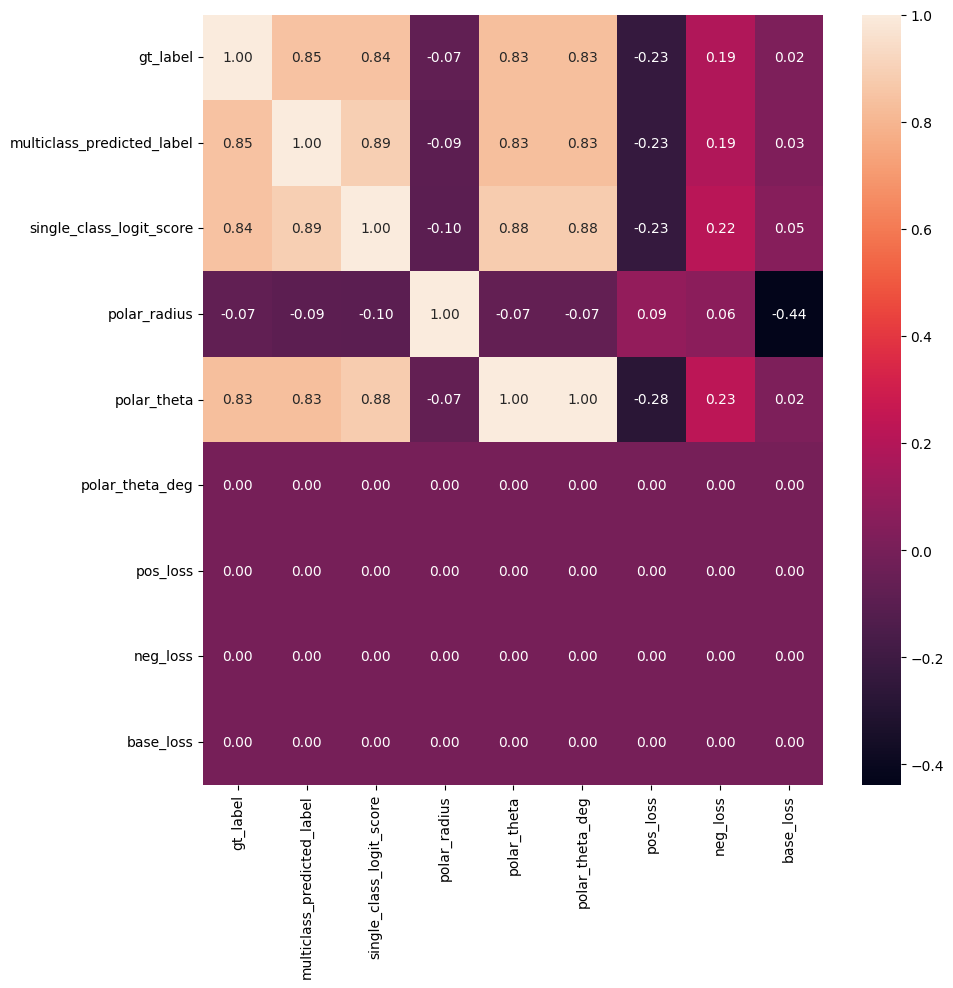

In [39]:
# plot correlation matrix with labels on x and y axis as columns
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", xticklabels=numerical_cols, yticklabels=numerical_cols)

In [40]:
# present coorelation matrix as a dataframe
correlation_df = pd.DataFrame(correlation_matrix, columns=numerical_cols, index=numerical_cols)

In [41]:
correlation_df

,gt_label,multiclass_predicted_label,single_class_logit_score,polar_radius,polar_theta,polar_theta_deg,pos_loss,neg_loss,base_loss
gt_label,1.000000,0.845793,0.844571,-0.072942,0.832945,0.832945,-0.233025,0.187980,0.017942
multiclass_predicted_label,0.845793,1.000000,0.892107,-0.091256,0.833823,0.833823,-0.234113,0.188040,0.027235
single_class_logit_score,0.844571,0.892107,1.000000,-0.098410,0.878955,0.878955,-0.233547,0.219068,0.048061
polar_radius,-0.072942,-0.091256,-0.098410,1.000000,-0.071894,-0.071894,0.090592,0.062187,-0.437731
polar_theta,0.832945,0.833823,0.878955,-0.071894,1.000000,1.000000,-0.278213,0.228511,0.018254
polar_theta_deg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pos_loss,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
neg_loss,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
base_loss,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
def plot_violin(df, metric_1, metric_2, prefix='Raw'):
    assert(metric_2=="gt_label")
    plt.figure(figsize=(8, 6))
    
    # Color palette (using 'Set1' as before)
    color_palette = sns.color_palette("Set1", n_colors=5)
    
    # Create violin plot
    sns.violinplot(x=df[metric_2], y=df[metric_1], palette=color_palette)
    
    # Calculate and annotate means and std-devs
    grouped = df.groupby(metric_2)
    means = grouped[metric_1].mean()
    stds = grouped[metric_1].std()
    
    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(i, plt.ylim()[0], f'Mean: {mean:.2f}\nStd: {std:.2f}', 
                 ha='center', va='bottom', fontweight='bold')
    
    # Set labels and title
    plt.xlabel(metric_2)
    plt.ylabel(metric_1)
    plt.title(f'Violin Plot of {metric_1} by {metric_2}')
    
    # Adjust layout to prevent cutting off annotations
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'./violin_plots/{metric_1}_{metric_2}_{prefix}_violin.png', dpi=600)
    plt.show()

In [ ]:
metrics_want = ['polar_theta_deg', 'polar_radius', 'pos_loss', 'neg_loss', 'base_loss', 'single_class_logit_score', 'multiclass_predicted_label', 'gt_label']
for metric_1 in metrics_want:
    metric_2 = "gt_label"
    plot_violin(data_df, metric_1, metric_2)

In [ ]:
# plot some qualitative examples
# find examples where 'polar_deg_theta' > 60 and "gt_label" == 4 and "multiclass_predicted_label" == 0
want_df = data_df[(data_df["polar_theta_deg"] > 50) & (data_df["gt_label"] >2) & (data_df["single_class_logit_score"] <0.3)]
# sort in reverse order of len(x['text'])
#TODO:
want_df = want_df.sort_values(by='text', key=lambda x: x.str.len(), ascending=False)
# print text and polar_theta_deg and gt_label and multiclass_predicted_label
for i in range(len(want_df)):
    print(want_df.iloc[i]["text"])
    print(want_df.iloc[i]["polar_theta_deg"])
    print(want_df.iloc[i]["polar_radius"])
    print(want_df.iloc[i]["gt_label"])
    print(want_df.iloc[i]["multiclass_predicted_label"])
    print(want_df.iloc[i]["single_class_logit_score"])
    print("#################")

In [ ]:
# plot some qualitative examples
# find examples where 'polar_deg_theta' > 60 and "gt_label" == 4 and "multiclass_predicted_label" == 0
want_df = data_df[(data_df["polar_theta_deg"] > 35)  | (data_df["polar_theta_deg"] <55) ]
want_df = want_df[(data_df["gt_label"] ==2)]
want_df = want_df[(data_df["multiclass_predicted_label"] !=2)]

# sort in reverse order of len(x['text'])
#TODO:
want_df = want_df.sort_values(by='text', key=lambda x: x.str.len(), ascending=False)
# print text and polar_theta_deg and gt_label and multiclass_predicted_label
for i in range(len(want_df)):
    print(want_df.iloc[i]["text"])
    print(want_df.iloc[i]["polar_theta_deg"])
    print(want_df.iloc[i]["polar_radius"])
    print("GT:", want_df.iloc[i]["gt_label"])
    print("Multi:", want_df.iloc[i]["multiclass_predicted_label"])
    print(want_df.iloc[i]["single_class_logit_score"])
    print("#################")

In [43]:
data_df

,text,gt_label,multiclass_predicted_label,single_class_logit_score,polar_radius,polar_theta,polar_theta_deg,pos_loss,neg_loss,base_loss
0,I got 'new' tires from them and within two wee...,0,0,0.000179,0.893337,0.679533,38.934379,3.637170,3.423840,4.001163
1,Don't waste your time. We had two different p...,0,0,0.000444,0.519094,0.626527,35.897380,3.356954,3.033727,4.223260
2,All I can say is the worst! We were the only 2...,0,0,0.000043,0.889150,0.656323,37.604547,3.785630,3.524564,4.136008
3,I have been to this restaurant twice and was d...,0,0,0.000004,0.875254,0.552706,31.667748,3.353036,2.869883,3.647495
4,Food was NOT GOOD at all! My husband & I ate h...,0,0,0.000013,0.799081,0.636228,36.453198,3.176172,2.873306,3.618195
...,...,...,...,...,...,...,...,...,...,...
49995,Just wanted to write a review to chip in with ...,0,1,0.002904,1.133103,0.709637,40.659229,3.798547,3.646442,3.949870
49996,Great ambience. Great drinks. Great food. I lo...,4,4,0.999981,0.720631,1.152153,66.013533,2.362278,3.172081,3.590026
49997,I have been to the other Monks locations so I ...,3,3,0.999862,0.655790,0.838733,48.055875,3.373806,3.480679,4.198580
49998,Don't go here. I know you might want to try i...,1,1,0.001741,0.883173,0.654348,37.491350,3.848746,3.583591,4.204350


In [44]:
# save dataframe as a csv file
save_path = "./data/combined_data.csv"
data_df.to_csv(save_path, index=False)